# 21 Moving Average Reversion Strategy

In [1]:
#!pip install oandapyV20

In [2]:
#!pip install zulu

In [3]:
#!pip install mpl_finance

In [1]:
import numpy as np
import pandas as pd
import oandapyV20
import oandapyV20.endpoints.instruments as instruments
import matplotlib.dates as mpl_dates
import matplotlib.pyplot as plt
from mpl_finance import candlestick_ohlc
import datetime
import zulu
import os

pd.set_option('display.float_format', '{:.4f}'.format)

In [2]:
ID = '101-004-9949998-001'
token = '4900a27fe17ab573d490ce234465329f-6633f44d08bf25b48ceaacd2c7917674'

In [3]:
client = oandapyV20.API(access_token=token)

# 21 Moving Average Reversion strategy on EURUSD

In [4]:
# Loop to create the dataset

Date = pd.Series(datetime.datetime(2010, 4, 1, 0, 0, 0))
eurusd = pd.DataFrame()


while Date.iloc[-1].year != 2020 or Date.iloc[-1].month != 4:
    
    last = Date.iloc[-1]
    inizio = last + datetime.timedelta(minutes=15)
    inizio = zulu.create(inizio.year, inizio.month, inizio.day, inizio.hour, inizio.minute)
    inizio = inizio.isoformat('T')+'Z'
    inizio = str(inizio[:-8] + 'Z')

    params = {
            "from": inizio,
            "granularity": "M15"}

    r = instruments.InstrumentsCandles(instrument="EUR_USD",
                                       params=params)

    rv = client.request(r)

    newDat = []
    for oo in r.response['candles']:
        newDat.append([oo['time'], oo['mid']['o'], oo['mid']['h'], oo['mid']['l'], oo['mid']['c']])
    
    newEurusd = pd.DataFrame(newDat)
    newEurusd.columns = ['Time', 'Open', 'High', 'Low', 'Close']
    newEurusd["Time"] = pd.to_datetime(newEurusd['Time'])
    Date = Date.append(newEurusd['Time'])
    newEurusd['Time'] = newEurusd['Time'].apply(mpl_dates.date2num)
    newEurusd = newEurusd.astype(float)
    eurusd = eurusd.append(newEurusd)
    
#Adjusting so that eurusd and Date match
Date = Date.drop(index=0)
eurusd = eurusd.drop(index=0)

eurusd.index = range(eurusd.shape[0])
Date.index = range(eurusd.shape[0])

eurusd.head()

,Time,Open,High,Low,Close
0,733863.0208,1.3552,1.3554,1.3544,1.3546
1,733863.0312,1.3546,1.3547,1.3526,1.3530
2,733863.0417,1.3530,1.3530,1.3518,1.3518
3,733863.0521,1.3518,1.3520,1.3512,1.3517
4,733863.0625,1.3517,1.3517,1.3507,1.3514


In [5]:
#First and Last Day of the dataset
print(eurusd.shape)
print(Date.iloc[0])
print(Date.iloc[-1])
print(eurusd.head(5))

(250997, 5)
2010-04-01 00:30:00
2020-04-01 22:15:00
         Time   Open   High    Low  Close
0 733863.0208 1.3552 1.3554 1.3544 1.3546
1 733863.0312 1.3546 1.3547 1.3526 1.3530
2 733863.0417 1.3530 1.3530 1.3518 1.3518
3 733863.0521 1.3518 1.3520 1.3512 1.3517
4 733863.0625 1.3517 1.3517 1.3507 1.3514


### Definition of the Moving Average

In [6]:
def CrossMovingAverage(rates, fast_period, slow_period):
    fastMA=[]
    slowMA=[]
    
    fastMA = eurusd['Close'].rolling(fast_period).mean()
    slowMA= eurusd['Close'].rolling(slow_period).mean()
        
    return slow_period, fastMA, slowMA

In [7]:
slow_period, fastMA, slowMA = CrossMovingAverage(eurusd, 8, 21)

eurusd["fastMA"] = fastMA
eurusd["slowMA"] = slowMA

eurusd = eurusd.iloc[21:]
eurusd.index = range(eurusd.shape[0])

data = {'close':eurusd["Close"],'fastMA':fastMA, 'slowMA':slowMA}

flag = pd.DataFrame(data)

flag.index = range(flag.shape[0])
flag = flag.drop(flag.index[0:21])
flag.index = range(flag.shape[0])

In [8]:
plt.style.use('ggplot')

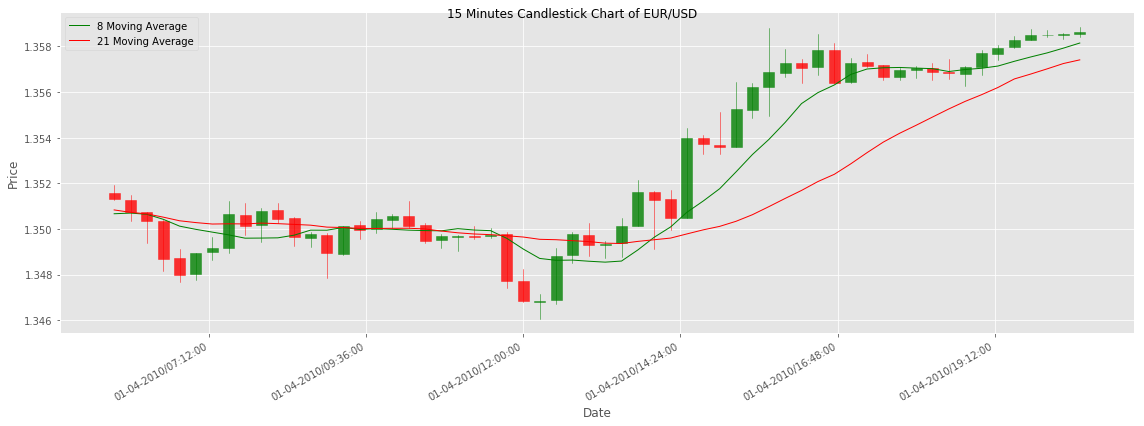

In [9]:
# Creating Subplots
fig, ax = plt.subplots(figsize = (16,6))

candlestick_ohlc(ax, eurusd.iloc[range(60), range(5)].values, width=0.007, colorup='green', colordown='red', alpha=0.8)
ax.plot(eurusd['Time'][:60], eurusd["fastMA"][:60], color = 'green', linewidth = 1, label='8 Moving Average')
ax.plot(eurusd['Time'][:60], eurusd["slowMA"][:60], color = 'red', linewidth = 1, label='21 Moving Average')
leg = ax.legend();

# Setting labels & titles
ax.set_xlabel('Date')
ax.set_ylabel('Price')
fig.suptitle('15 Minutes Candlestick Chart of EUR/USD')

# Formatting Date
date_format = mpl_dates.DateFormatter('%d-%m-%Y/%H:%M:%S')
ax.xaxis.set_major_formatter(date_format)
fig.autofmt_xdate()

fig.tight_layout()

plt.show()

In [10]:
print(eurusd.shape)
print(flag.shape)

(250976, 7)
(250976, 3)


### Strategy - buy or sell if the price is far from the 21 Moving Average

In [11]:
# Creating boolean values if the below conditions are true
flag["distance"] = np.where(flag["close"] >= flag["slowMA"], (flag["close"]-flag["slowMA"])*10000, (flag["close"]-flag["slowMA"])*10000 )

In [12]:
flag.head(10)

,close,fastMA,slowMA,distance
0,1.3497,1.3507,1.3508,-11.3095
1,1.3497,1.3507,1.3507,-10.6524
2,1.3497,1.3506,1.3507,-9.1714
3,1.3477,1.3504,1.3505,-28.1476
4,1.3468,1.3501,1.3504,-35.3524
5,1.3469,1.3500,1.3503,-34.1524
6,1.3488,1.3499,1.3502,-13.9238
7,1.3498,1.3497,1.3502,-4.6333
8,1.3493,1.3496,1.3502,-9.1714
9,1.3493,1.3496,1.3503,-9.1381


In [13]:
flag["buyTrigger"] = 0
flag["buyWin"] = 0 
flag["sellTrigger"] = 0 
flag["sellWin"] = 0 

In [14]:
flag["buyTrigger"] = np.where(flag["distance"]<-0.01, 1,0)
flag["buyWin"] = np.where(flag["distance"]>0, 1,0)
flag["sellTrigger"] = np.where(flag["distance"]>0.01, 1,0)
flag["sellWin"] = np.where(flag["distance"]<0, 1,0)

flag.head(10)

,close,fastMA,slowMA,distance,buyTrigger,buyWin,sellTrigger,sellWin
0,1.3497,1.3507,1.3508,-11.3095,1,0,0,1
1,1.3497,1.3507,1.3507,-10.6524,1,0,0,1
2,1.3497,1.3506,1.3507,-9.1714,1,0,0,1
3,1.3477,1.3504,1.3505,-28.1476,1,0,0,1
4,1.3468,1.3501,1.3504,-35.3524,1,0,0,1
5,1.3469,1.3500,1.3503,-34.1524,1,0,0,1
6,1.3488,1.3499,1.3502,-13.9238,1,0,0,1
7,1.3498,1.3497,1.3502,-4.6333,1,0,0,1
8,1.3493,1.3496,1.3502,-9.1714,1,0,0,1
9,1.3493,1.3496,1.3503,-9.1381,1,0,0,1


_I defines a winning trade when a Trigger column is equal to 1 and then the corresponding Win column is 1_

In [15]:
flag.head(13)

,close,fastMA,slowMA,distance,buyTrigger,buyWin,sellTrigger,sellWin
0,1.3497,1.3507,1.3508,-11.3095,1,0,0,1
1,1.3497,1.3507,1.3507,-10.6524,1,0,0,1
2,1.3497,1.3506,1.3507,-9.1714,1,0,0,1
3,1.3477,1.3504,1.3505,-28.1476,1,0,0,1
4,1.3468,1.3501,1.3504,-35.3524,1,0,0,1
5,1.3469,1.3500,1.3503,-34.1524,1,0,0,1
6,1.3488,1.3499,1.3502,-13.9238,1,0,0,1
7,1.3498,1.3497,1.3502,-4.6333,1,0,0,1
8,1.3493,1.3496,1.3502,-9.1714,1,0,0,1
9,1.3493,1.3496,1.3503,-9.1381,1,0,0,1


In [16]:
# I create a data frame with values of the maximum distance from the slow MA of every buy order
prev = 0
splits = np.append(np.where(np.diff(flag["buyTrigger"]) != 0)[0],len(flag["buyTrigger"])+1)
indici = []
maxBuyDistance = []

for split in splits:
    
    indici = []
    
    indici = np.arange(1,flag["buyTrigger"].size+1,1)[prev:split]
    maxBuyDistance.append(min(flag.loc[indici]["distance"]))
    prev = split
    

data = {'maxBuyDistance':maxBuyDistance}
longDistance = pd.DataFrame(data=data, index=range(len(maxBuyDistance)))
longDistance['maxBuyDistance'] = np.where(longDistance<0, longDistance,0)
longDistance = longDistance.replace(0, pd.np.nan).dropna(axis=0, how='all').fillna(0)
longDistance.head(5)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':


,maxBuyDistance
0,-35.3524
2,-81.8952
4,-5.7952
6,-0.6190
8,-52.2095


In [17]:
# I create a data frame with values of the maximum distance from the slow MA of every sell order
prev = 0
splits = np.append(np.where(np.diff(flag["sellTrigger"]) != 0)[0],len(flag["sellTrigger"])+1)
indici = []
maxSellDistance = []

for split in splits:
    
    indici = []
    
    indici = np.arange(1,flag["sellTrigger"].size+1,1)[prev:split]
    maxSellDistance.append(max(flag.loc[indici]["distance"]))
    prev = split
    

data = {'maxSellDistance':maxSellDistance}
sellDistance = pd.DataFrame(data=data, index=range(len(maxSellDistance)))
sellDistance['maxSellDistance'] = np.where(sellDistance>0, sellDistance,0)
sellDistance = sellDistance.replace(0, pd.np.nan).dropna(axis=0, how='all').fillna(0)
sellDistance.head(5)

C:\Users\HP\Anaconda3\lib\site-packages\ipykernel_launcher.py:12: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  if sys.path[0] == '':


,maxSellDistance
1,87.0286
3,0.8762
5,10.6333
7,40.0810
9,28.3333


## Stats: average max distance from the 21 period MA

In [18]:
print("Long trades: " + str(len(longDistance["maxBuyDistance"])))
print("Average max distance from the 21 period MA: " + str(longDistance["maxBuyDistance"].mean()))

Long trades: 7815
Average max distance from the 21 period MA: -19.77112573482208


In [19]:
print("Short trades: " + str(len(sellDistance["maxSellDistance"])))
print("Average max distance from the 21 period MA: " + str(sellDistance["maxSellDistance"].mean()))

Short trades: 7839
Average max distance from the 21 period MA: 19.65615694439738
